## Summary
For calculating land cover change within polygons. Used for whitefish lake for Karen Wang and Jonathan Wang ABoVE land cover dataset- multitemporal.
EDK 2021.11.19
TODO: 
* Can use zonal statistics on multiple polygons (buffers) at once, instead of in loop.

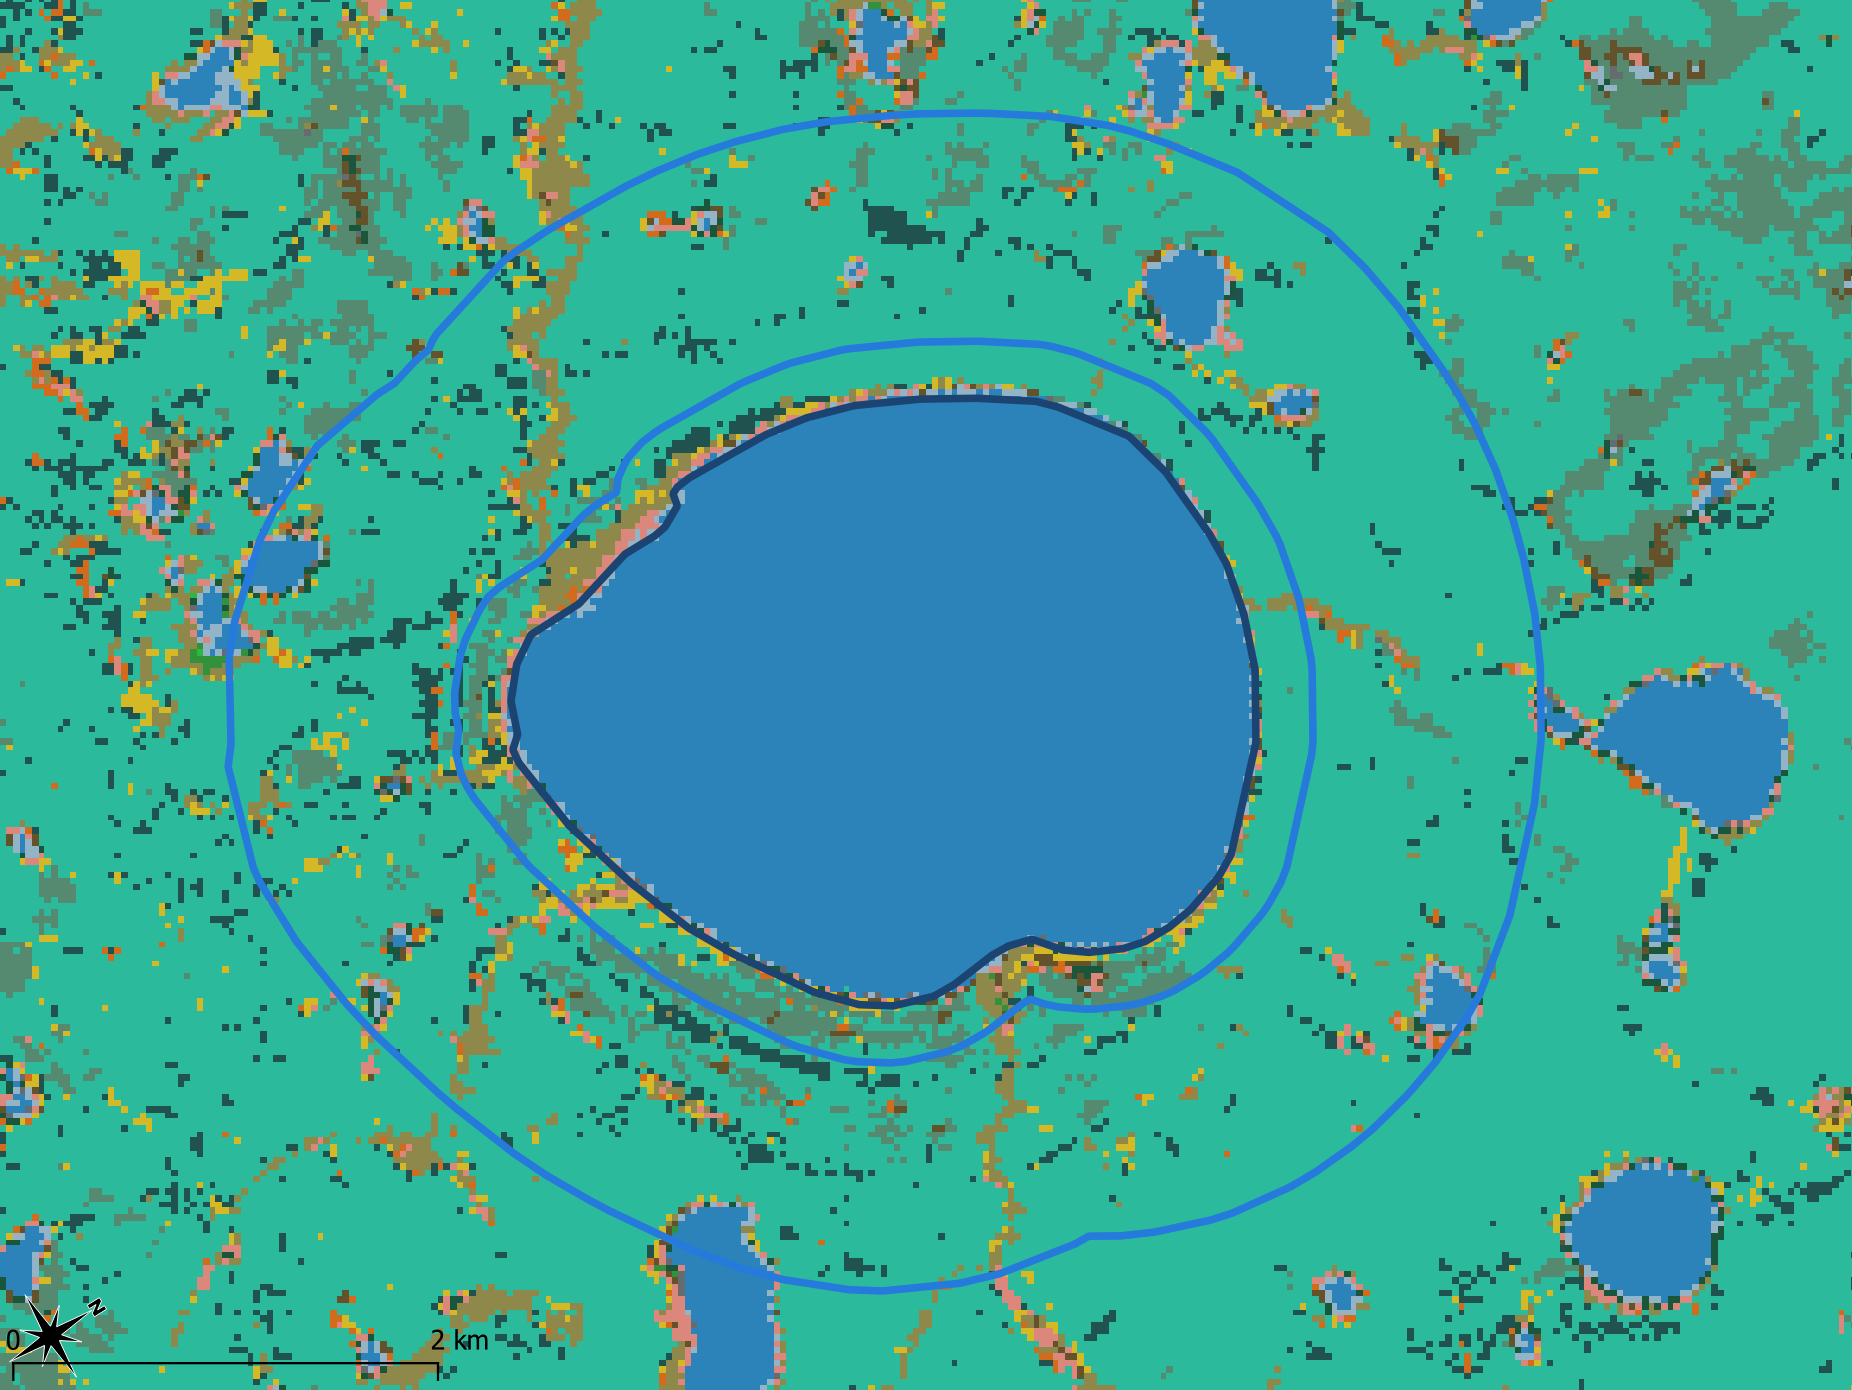

In [130]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import reshape_as_image
import fiona
import rasterio.mask
# from scipy.stats import binned_statistic
from rasterstats import zonal_stats

In [242]:
## I/O
## in
pth_shp_in = '/mnt/g/Land-cover-whitefish-lk-ak/whitefish-lk-albers.shp'
pth_roi_in = '/mnt/g/Land-cover-whitefish-lk-ak/roi_albers.shp'
pth_lc_in = '/mnt/f/Wang-above-land-cover/ABoVE_LandCover_Bh04v01.tif'

## out
pth_csv_out_inner = '/mnt/g/Land-cover-whitefish-lk-ak/out/stats/whitefish-lk-land-cover-change-b279.csv'
pth_csv_out_outer = '/mnt/g/Land-cover-whitefish-lk-ak/out/stats/whitefish-lk-land-cover-change-b1350.csv'


## buffers
buffer_lengths=np.arange(90, 7000, 90)

## classes for land cover 
nclasses = 15
classes = ['Evergreen Forest','Deciduous Forest',	'Mixed Forest',	'Woodland',	'Low Shrub',	'Tall Shrub',	'Open Shrubs',	'Herbaceous',	'Tussock Tundra',	'Sparsely Vegetated',	'Fen',	'Bog',	'Shallows/littoral',	'Barren',	'Water']

## dynamic values
nBuffers = buffer_lengths.size

In [69]:
## roi for cropping
with fiona.open(pth_roi_in, "r") as shapefile:
    roi = [feature["geometry"] for feature in shapefile]

In [122]:
## load and buffer polygon
shp = gpd.read_file(pth_shp_in)
for i, length in enumerate(buffer_lengths):
    if i==0:
        buffers = shp.buffer(length)
    else:
        buffers = buffers.append(shp.buffer(length), True)

In [179]:
## load raster subset
with rio.open(pth_lc_in) as src:
        lc, lc_transform = rasterio.mask.mask(src, roi, crop=True)
        lc_meta = src.meta
        # lc = src.read()
        lc = reshape_as_image(lc)
        src_crs=src.crs
        src_res=src.res
        src_shp=src.shape
nYears = lc.shape[2]

## Zonal statistics

In [162]:
a = np.histogram(np.ndarray.flatten(lc[:,:,0]), range=[1,nclasses+1], bins = nclasses)
np.histogram_bin_edges
# np.ndarray.flatten(lc[:,:,0]).shape
a

(array([  2478,      2,    110,   2950,   7884,  14190,   2336, 291223,
         10914,  32248,   4978,      9,   4255,    977,  39846]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16.]))

In [205]:
def my_hist(lc):
    ''' Gives counts for each integer-valued landcover class, with total number hard-coded in as nclasses.'''
    return np.histogram(np.ndarray.flatten(lc), range=[1,nclasses+1], bins = nclasses)[0] # bin counts

In [206]:
# zonal_stats(shp, lc[:,:,0], affine=lc_transform, stats='count unique')
stat = zonal_stats(shp, lc[:,:,0], affine=lc_transform, stats='count unique', add_stats = {'histogram':my_hist}, nodata=255)
print(stat)
stat[0]['histogram']
# stat

[{'count': 8417, 'unique': 10, 'histogram': array([  32,    0,    3,   65,  205,  315,   39, 1648,  187,  403,  175,
          0,  155,   14, 8302])}]


array([  32,    0,    3,   65,  205,  315,   39, 1648,  187,  403,  175,
          0,  155,   14, 8302])

In [234]:
array=np.full([nYears, nclasses, nBuffers], np.nan, dtype='uint32') # init array for outpu
for j, ring in enumerate(buffers[0:16]): # TODO change number
    for i, year in enumerate(range(nYears)):
        stat = zonal_stats(ring, lc[:,:,i], affine=lc_transform, stats='count unique', add_stats = {'histogram':my_hist}, nodata=255)
        array[i,:,j] = stat[0]['histogram']
# Source: https://automating-gis-processes.github.io/CSC/notebooks/L5/zonal-statistics.html

In [238]:
## convert to km2
array = array*np.prod(src_res)/10000


## convert to pd df
dfb3 = pd.DataFrame(array[:,:,2], index = np.arange(1984, 2014+1), columns = classes)
dfb15 = pd.DataFrame(array[:,:,14], index = np.arange(1984, 2014+1), columns = classes)

dfb15

,Evergreen Forest,Deciduous Forest,Mixed Forest,Woodland,Low Shrub,Tall Shrub,Open Shrubs,Herbaceous,Tussock Tundra,Sparsely Vegetated,Fen,Bog,Shallows/littoral,Barren,Water
1984,1.2312,0.0000,0.0891,1.6605,5.2731,9.0963,1.5471,195.5907,10.4571,13.5999,3.5559,0.0,2.5920,0.3159,71.5635
1985,1.2312,0.0000,0.0891,1.6605,5.2731,9.0963,1.5471,195.5907,10.4571,13.5999,3.5559,0.0,2.5920,0.3159,71.5635
1986,1.2312,0.0000,0.0891,1.6605,5.2731,9.0963,1.5471,195.5907,10.4571,13.5999,3.5559,0.0,2.5920,0.3159,71.5635
1987,1.2312,0.0000,0.0891,1.6605,5.2731,9.0963,1.5471,195.5907,10.4571,13.5999,3.5559,0.0,2.5920,0.3159,71.5635
1988,1.2312,0.0000,0.0891,1.6605,5.2731,9.0963,1.5471,195.5907,10.4571,13.5999,3.5559,0.0,2.5920,0.3159,71.5635
1989,1.2312,0.0000,0.0891,1.6605,5.2731,9.0963,1.5471,195.5907,10.4571,13.5999,3.5559,0.0,2.5920,0.3159,71.5635
1990,1.2312,0.0000,0.0891,1.6605,5.2731,9.0963,1.5471,195.5907,10.4571,13.5999,3.5559,0.0,2.5920,0.3159,71.5635
1991,1.2312,0.0000,0.0891,1.6605,5.2731,9.0963,1.5471,195.5907,10.4571,13.5999,3.5559,0.0,2.5920,0.3159,71.5635
1992,1.2312,0.0000,0.0891,1.6605,5.2731,9.0963,1.5471,195.5907,10.4571,13.5999,3.5559,0.0,2.5920,0.3159,71.5635
1993,1.2312,0.0000,0.0891,1.6605,5.2731,9.0963,1.5471,195.5907,10.4571,13.5999,3.5559,0.0,2.5920,0.3159,71.5635


In [241]:
## write out
dfb3.to_csv(pth_csv_out_inner)
dfb15.to_csv(pth_csv_out_outer)

In [208]:
np.full([nYears, nclasses, nBuffers], np.nan, dtype='uint32') # init array for outpu
lc[:,:,i]
j
buffers
nclasses
# stat[0]['histogram']
array

array([[[  32,   32,   35, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   3,    3,    3, ...,    0,    0,    0],
        ...,
        [ 175,  178,  185, ...,    0,    0,    0],
        [  14,   14,   15, ...,    0,    0,    0],
        [8309, 8318, 8327, ...,    0,    0,    0]],

       [[  32,   32,   35, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   3,    3,    3, ...,    0,    0,    0],
        ...,
        [ 175,  178,  185, ...,    0,    0,    0],
        [  14,   14,   15, ...,    0,    0,    0],
        [8309, 8318, 8327, ...,    0,    0,    0]],

       [[  32,   32,   35, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   3,    3,    3, ...,    0,    0,    0],
        ...,
        [ 175,  178,  185, ...,    0,    0,    0],
        [  14,   14,   15, ...,    0,    0,    0],
        [8309, 8318, 8327, ...,    0,    0,    0]],

       ...,

       [[  34,   34,   3